In [1]:
#Preparing qiskit environment
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import IBMQ
from qiskit import Aer
from scipy import optimize
import sys, time
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(10)

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  "future release.", DeprecationWarning)


In [2]:
import sys
sys.path.append('../libmitigation')
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import depolarizing_error
import qiskit.ignis.mitigation as mit
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter
import importlib
from inv_sgs import InvSGS
from inv_s_sgs import InvSSGS
from inv_lm_sgs import InvLMSGS
from inv_s_lm_sgs import InvSLMSGS
from inv_s_lm0_sgs import InvSLM0SGS
from sgs_algorithm import sgs_algorithm

In [3]:
nbit = 3

In [4]:
noise_model = NoiseModel()
for qi in range(nbit):
    if qi >= 0:
        read_err = ReadoutError([[0.9, 0.1],[0.1,0.9]])
        noise_model.add_readout_error(read_err, [qi])

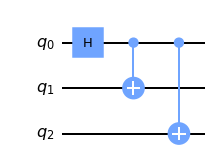

In [5]:
ghz = QuantumCircuit(nbit)
ghz.h(0)
for i in range(1,nbit):
    ghz.cx(0,i)
ghz.draw("mpl")

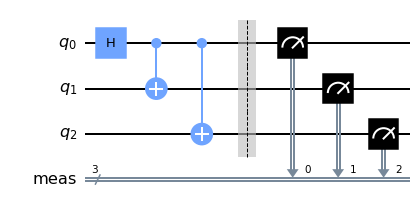

In [6]:
ghz.measure_all()
ghz.draw("mpl")

In [7]:
shots = 8192
qr = QuantumRegister(nbit)
mit_pattern = [[i] for i in range(nbit)]
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
job = execute(meas_calibs, backend=Aer.get_backend('qasm_simulator'), shots=shots, noise_model=noise_model)
cal_results = job.result()
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=mit_pattern)

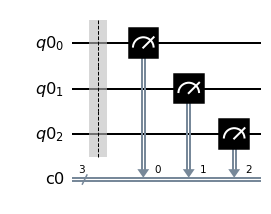

In [8]:
meas_calibs[0].draw("mpl")

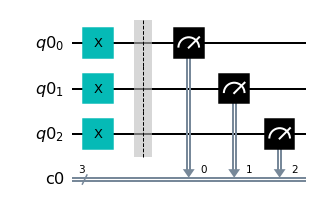

In [9]:
meas_calibs[1].draw("mpl")

In [10]:
raw_counts = execute(ghz, shots = 8192, backend=Aer.get_backend('qasm_simulator'), noise_model=noise_model).result().get_counts()

In [11]:
raw_counts

{'011': 360,
 '111': 3134,
 '101': 321,
 '100': 371,
 '001': 332,
 '110': 314,
 '000': 2975,
 '010': 385}

In [12]:
from qiskit.visualization import plot_histogram

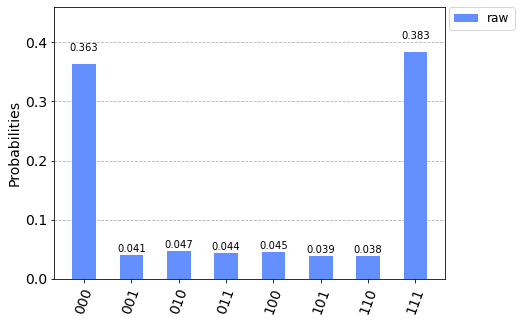

In [13]:
plot_histogram([raw_counts], legend=["raw"])

In [14]:
meas_filter = InvSGS(nbit, meas_fitter.cal_matrices, mit_pattern)
mit_counts = meas_filter.apply(raw_counts)

strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999996
number of positive values:  4
main process: Done!


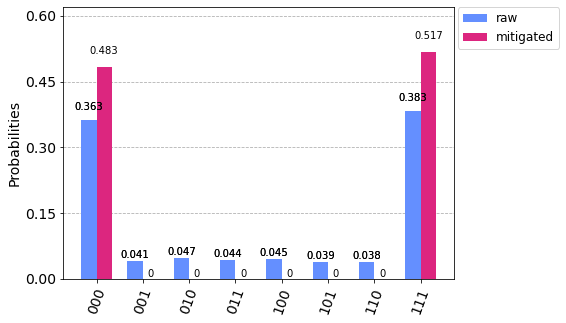

In [15]:
plot_histogram([raw_counts, mit_counts], legend=["raw", "mitigated"])

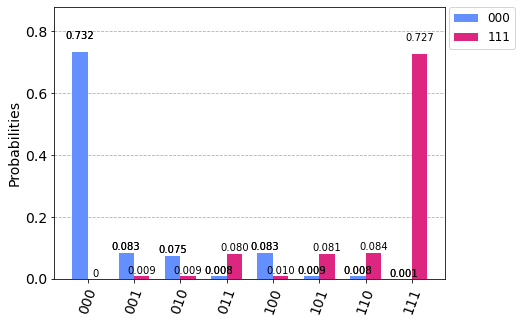

In [16]:
plot_histogram([cal_results.get_counts(0), cal_results.get_counts(1)], legend=["000","111"])

In [18]:
mit_nosgs_counts = meas_filter.apply(raw_counts, sgs=False, rescale=False)
mit_nosgs_counts

strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999996
main process: Done!


{0: 0.49579357661374174,
 1: -0.0058437933721548286,
 2: 0.009028936088084694,
 3: -0.00333318839002319,
 4: 0.0014833929411274078,
 5: -0.01064648934459059,
 6: -0.015530997893876722,
 7: 0.5290485633576911}

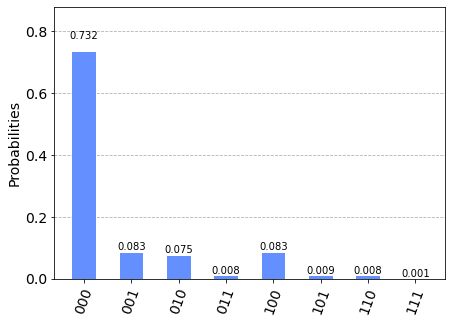

In [19]:
plot_histogram(cal_results.get_counts(0))

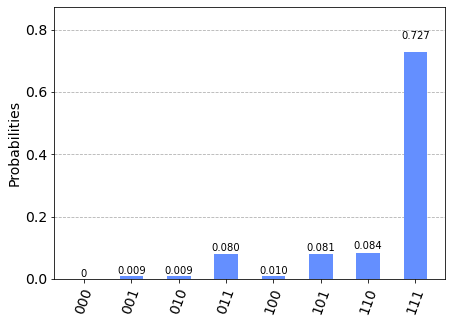

In [20]:
plot_histogram(cal_results.get_counts(1))

In [49]:
def flip_state(state, mat_index, flip_poses):
    """
    Flip the state according to the chosen qubit positions
    """
    if isinstance(state, str):
        flip_poses = [pos for i, pos in enumerate(flip_poses) if (mat_index >> i) & 1]
        print(flip_poses)
        flip_poses = sorted(flip_poses)
        new_state = ""
        pos = 0
        for flip_pos in flip_poses:
            new_state += state[pos:flip_pos]
            new_state += str(int(state[flip_pos], 2) ^ 1)  # flip the state
            pos = flip_pos + 1
        new_state += state[pos:]
        return new_state
    else:
        print(format(state, "06b"))
        for flip_pos in flip_poses:
            state = state ^ (1 << (6 - flip_pos))
            print(format(state, "06b"))
        return state

In [50]:
int("010001", 2)

17

In [52]:
format(flip_state(int("010001", 2), 3, [2,4]), "06b")

010001
000001
000101


'000101'